In [1]:
#!/usr/bin/env python3
from rosbags.rosbag1 import Reader
from rosbags.serde import deserialize_cdr, ros1_to_cdr
from rosbags.typesys import get_types_from_msg, register_types
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Unpack ROSBag

In [2]:
add_types = {}
msg_text = Path('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/vicon_bridge/msg/Marker.msg').read_text()
add_types.update(get_types_from_msg(msg_text, 'vicon_bridge/Marker'))
register_types(add_types)
msg_text = Path('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/vicon_bridge/msg/Markers.msg').read_text()
add_types.update(get_types_from_msg(msg_text, 'vicon_bridge/Markers'))
register_types(add_types)

In [3]:
t_count = 0
marker_pos = {t_count:[]}
prev_t = False
# with Reader('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/misc/marker_throw/throw_1.bag') as reader:
with Reader('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/misc/marker_throw/throw_2.bag') as reader:
    for connection, timestamp, rawdata in reader.messages():
        ## The local position message from the PX4
        if connection.topic == '/vicon/markers':
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
            if(len(msg.markers)):
                prev_t = True
                if(t_count not in marker_pos):
                    marker_pos[t_count] = []
                marker_pos[t_count].append([msg.markers[0].translation.x, msg.markers[0].translation.y, msg.markers[0].translation.z,msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9])
            else:
                if(prev_t):
                    prev_t = False
                    if(len(marker_pos[t_count])<50):
                        marker_pos[t_count] = []
                    else:
                        marker_pos[t_count] = np.array(marker_pos[t_count])
                        t_count += 1
                    

In [4]:
# for i in range(0, len(marker_pos)):
#     marker_ = np.array(marker_pos[i])
#     marker_[:,-1] = marker_[:,-1] - marker_[0,-1]
#     plt.scatter(marker_[:,-1], marker_[:,2])
#     plt.title('Marker Z Position vs Time Index: '+str(i))
#     plt.pause(0.1)

# Clean Parabola Data

In [5]:
def Parab(theta, v):
    g = -9.81
    k=10000
    points = []
    for t in range(0, k):
        step=t*0.001
        x_v = v * np.cos(np.deg2rad(theta))
        x =  x_v* step
        y=0
        z_v =v * np.sin(np.deg2rad(theta))+ 0.5 * g * step
        z = z_v*step
        if(z<0):
            break
        points.append([x,y,z,x_v,0,z_v])
    return np.array(points)
    # plt.plot(points[:, 0], points[:, 2])
    # plt.xlabel('Distance')
    # plt.ylabel('Height')
    # plt.title('Parabolic Trajectory')
    # plt.show()

# Kalman Filter 3D parabola fit

In [6]:
class KalmanFilter:
    def __init__(self, control_vec = np.array([0,0,-9.81])) -> None:
        # State Vector
        ## [x, y, z, vx, vy, vz]
        self.x = np.zeros((6,1))
        
        # Control Vector
        ## [ax, ay, az]
        self.u = control_vec.reshape((3,1))
        
        
        # Observation Matrix
        ## [x, y, z]
        self.H = np.array([[1,0,0,0,0,0],
                           [0,1,0,0,0,0],
                           [0,0,1,0,0,0]])
        
        # Covariance Matrix
        ## Defines how much we trust the state vector
        self.R = np.array([[0.005,0,0],
                           [0,0.005,0],
                           [0,0,0.005]])

        # Estimated State Vector
        ## [x, y, z, vx, vy, vz]
        self.x_hat = np.zeros((6,1))
        
        # Estimation Covariance Matrix (Uncertainty in the estimated state)
        ## Defines how much we trust the estimated state vector
        self.P = np.array([[0.01,0,0,0.001,0,0],
                           [0,0.01,0,0,0.001,0],
                           [0,0,0.01,0,0,0.001],
                           [0.001,0,0,500,0,0],
                           [0,0.001,0,0,500,0],
                           [0,0,0.001,0,0,500]])
        
        self.P_hat = np.zeros((6,6))
        
        self.P_hist = []
        self.X_hist = []
        
        self.dt = None
    
    
    # Process Noise
    ## Defines how much noise we expect in the modeled system
    @property
    def Q(self):
        dt = self.dt
        return np.array([[0.25*dt**4,0,0,0.5*dt**3,0,0],
                         [0,0.25*dt**4,0,0,0.5*dt**3,0],
                         [0,0,0.25*dt**4,0,0,0.5*dt**3],
                         [0.5*dt**3,0,0,dt**2,0,0],
                         [0,0.5*dt**3,0,0,dt**2,0],
                         [0,0,0.5*dt**3,0,0,dt**2]])
    @property
    def A(self):
        dt = self.dt
        return np.array([[1,0,0,dt,0,0],
                         [0,1,0,0,dt,0],
                         [0,0,1,0,0,dt],
                         [0,0,0,1,0,0],
                         [0,0,0,0,1,0],
                         [0,0,0,0,0,1]])
    
    @property
    def B(self):
        dt = self.dt
        return np.array([[0.5*dt**2,0,0],
                         [0,0.5*dt**2,0],
                         [0,0,0.5*dt**2],
                         [dt,0,0],
                         [0,dt,0],
                         [0,0,dt]])
        
    def step(self, dt = None, z = None):
        if dt is not None:
            self.dt = dt
        #Predict the state and covariance matrix
        self.predict()
        
        #In case of a measurement update
        if(z is not None):
            #Calculate the Kalman Gain
            self.update(z)
        else:
            self.x = self.x_hat
            self.P = self.P_hat
            
        #Store the current state and covariance matrix
        self.P_hist.append(self.P)
        self.X_hist.append(self.x)
    
    def update(self, z):
        # Update the Kalman Gain vector
        self.K = self.P_hat.dot(self.H.T).dot(np.linalg.inv(self.H.dot(self.P_hat).dot(self.H.T) + self.R))
        # Update the estimate using the kalman gain
        self.x = self.x_hat + self.K.dot(z.reshape((3,1)) - self.H.dot(self.x_hat))
        
        # Update the covariance matrix
        self.P = (np.eye(6) - self.K.dot(self.H)).dot(self.P_hat).dot((np.eye(6) - self.K.dot(self.H)).T) + self.K.dot(self.R).dot(self.K.T)
        pass
    
    def predict(self):
        # Predicted State Vector
        self.x_hat = self.A.dot(self.x) + self.B.dot(self.u)
        # Predicted Covariance Matrix
        self.P_hat = self.A.dot(self.P).dot(self.A.T) + self.Q

# Test Filter Simulation

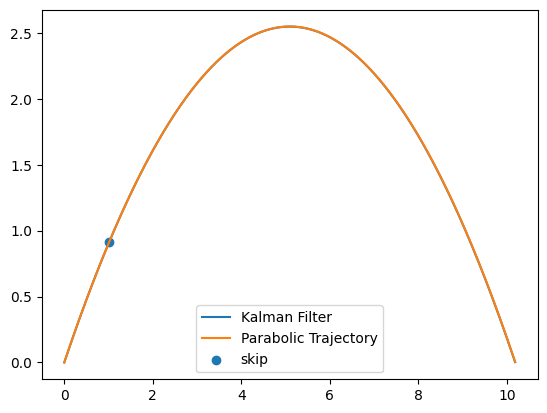

In [7]:
kf = KalmanFilter()

test_data = Parab(45, 10)
div = 10
lim = test_data.shape[0]//div


## Estimate the state using the Kalman Filter on the marker position
for wp, datap in enumerate(test_data):
    # print(marker_)
    if(wp<lim):
        kf.step(0.001, datap[:3])
    else:
        kf.step(0.001)

kf_state = np.array(kf.X_hist)
kf_cov = np.array(kf.P_hist)

#plot covariance

plt.plot(kf_state[:, 0], kf_state[:, 2], label = 'Kalman Filter')
plt.plot(test_data[:, 0], test_data[:, 2], label = 'Parabolic Trajectory')
plt.scatter(test_data[lim,0],test_data[lim,2], label = 'skip')
plt.legend()
plt.pause(0.05)

# for i in [3,5]:
#     plt.plot(kf_state[:,i]-2*np.sqrt(kf_cov[:,i,i]), '--r')
#     plt.plot(kf_state[:,i]+2*np.sqrt(kf_cov[:,i,i]), '--r')
#     plt.plot(kf_state[:,i], label = 'Kalman Filter')
#     plt.title('State {}'.format(i))
#     plt.legend()
#     plt.pause(0.05)



# Test Filter

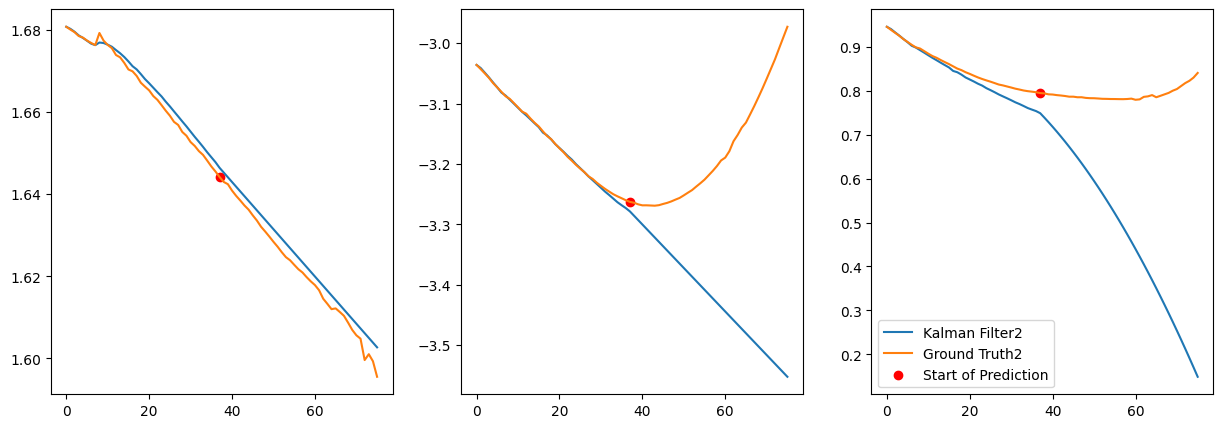

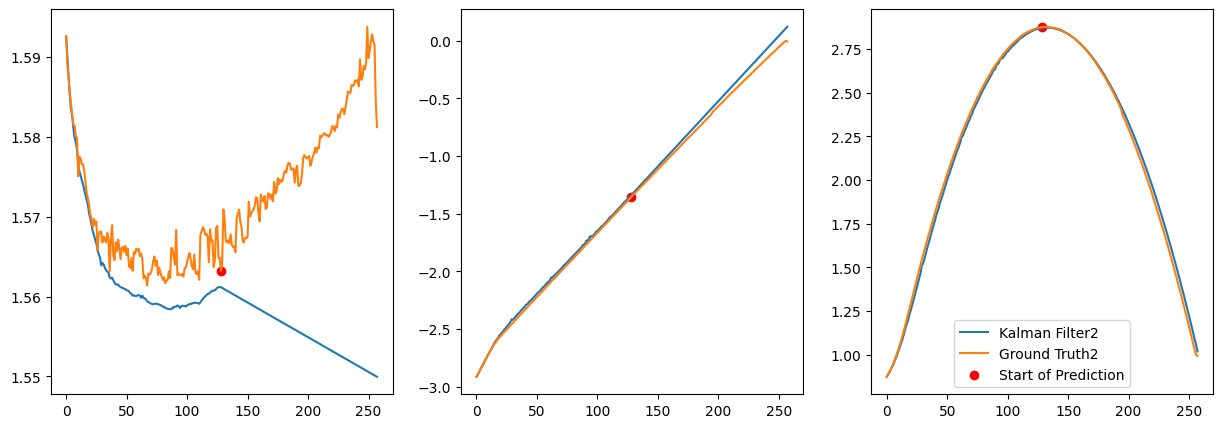

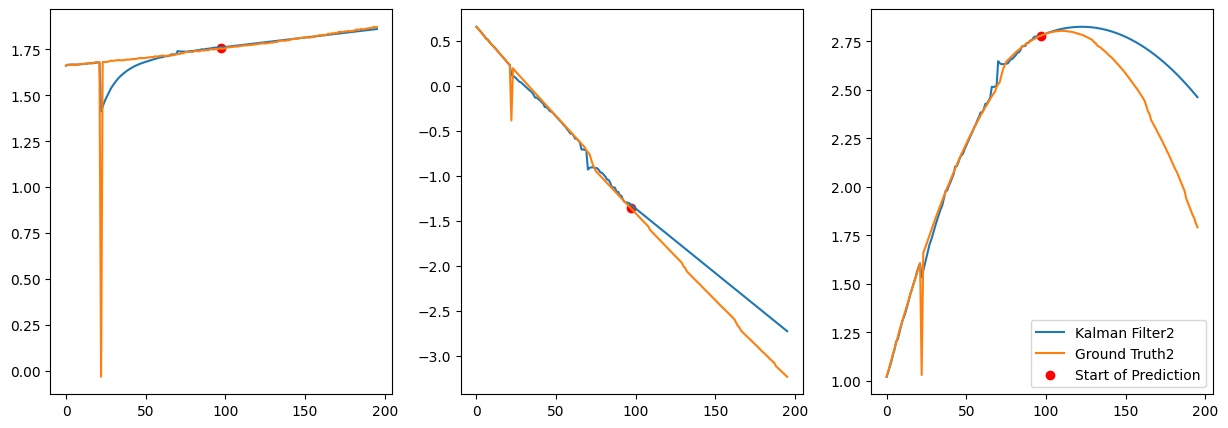

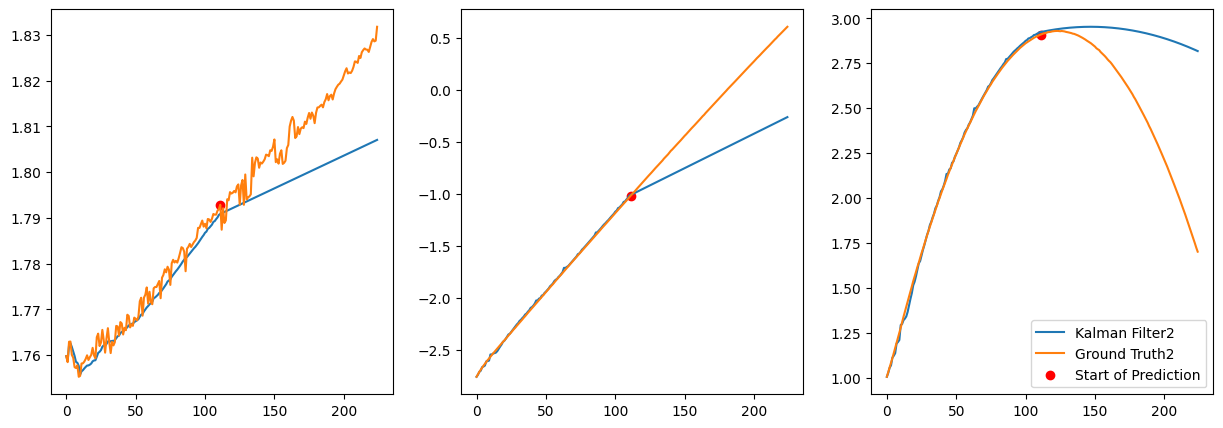

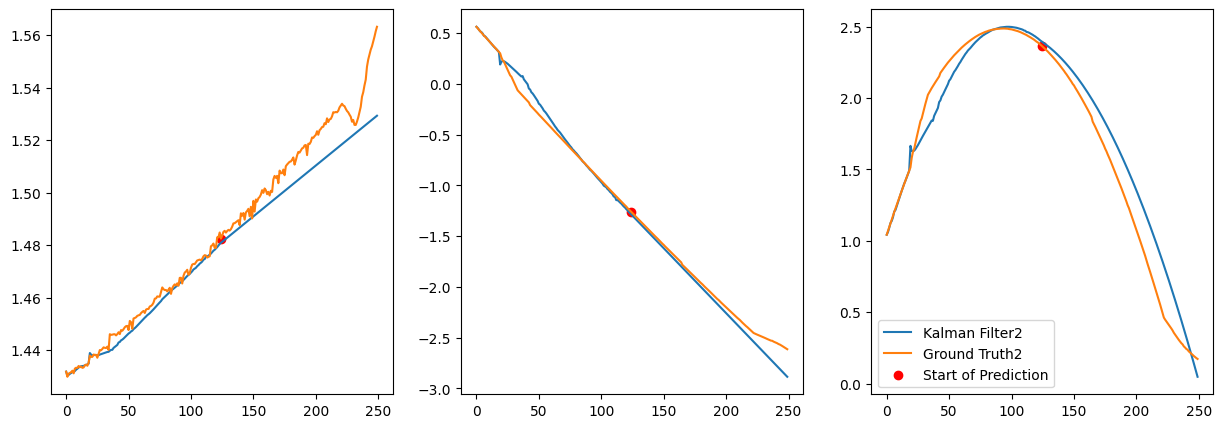

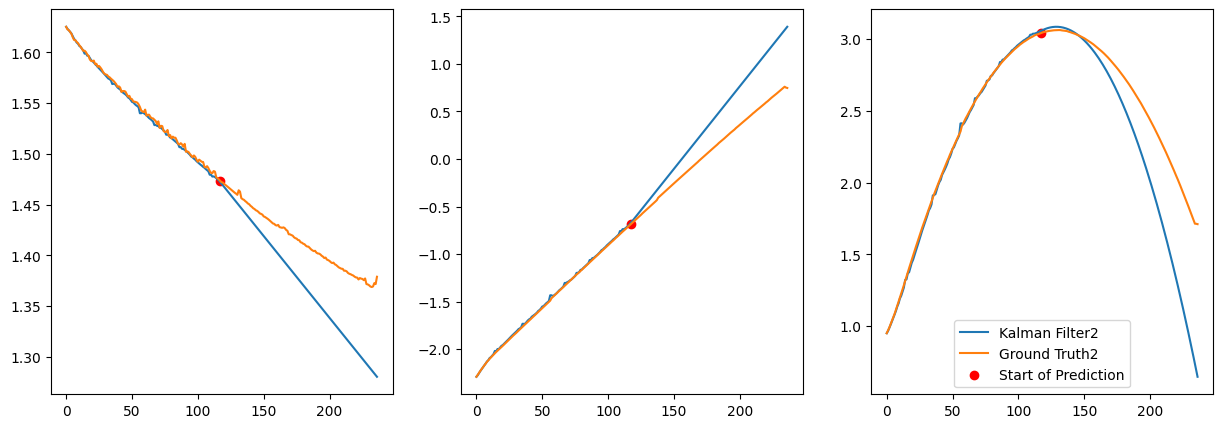

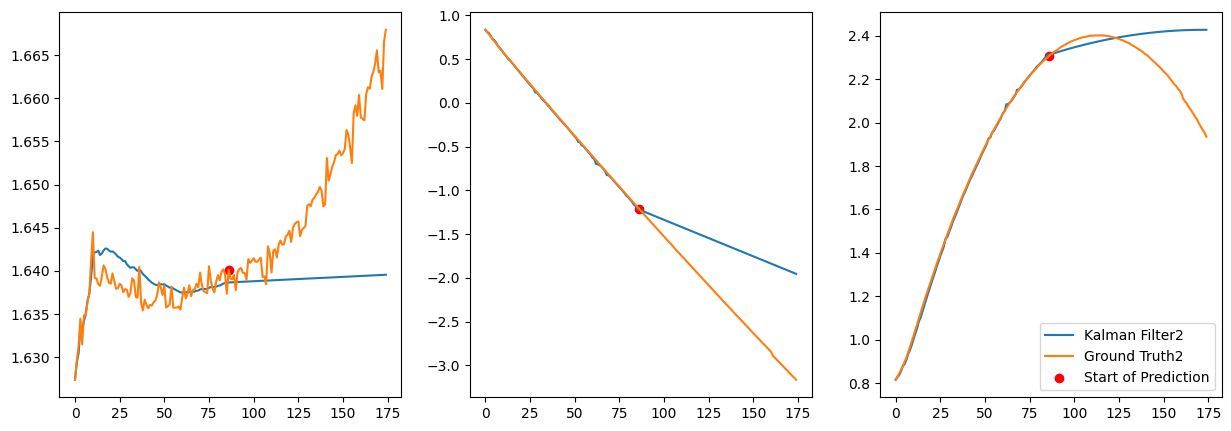

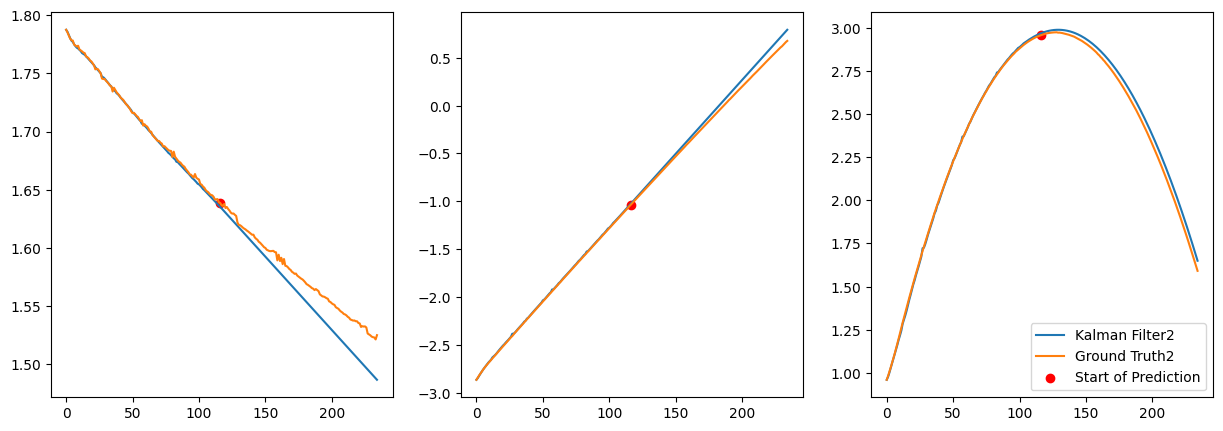

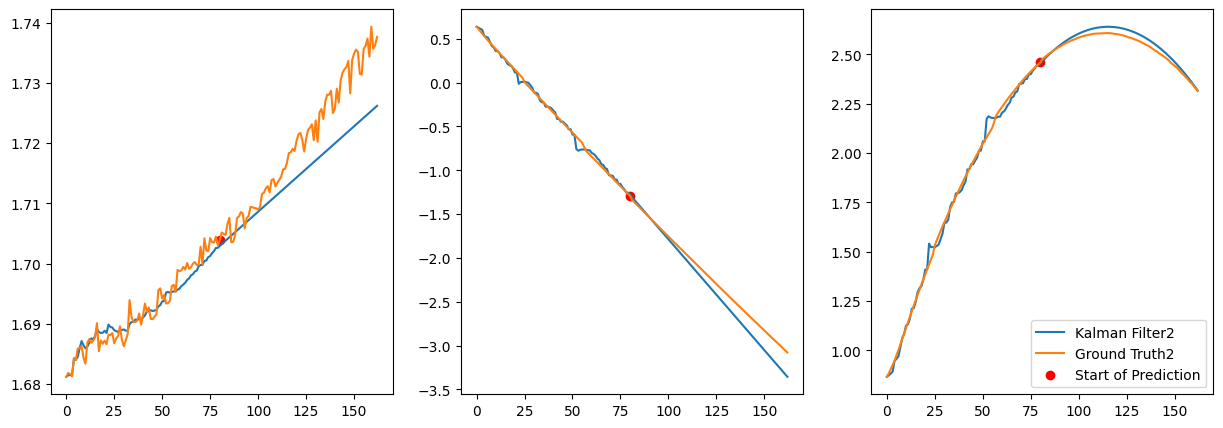

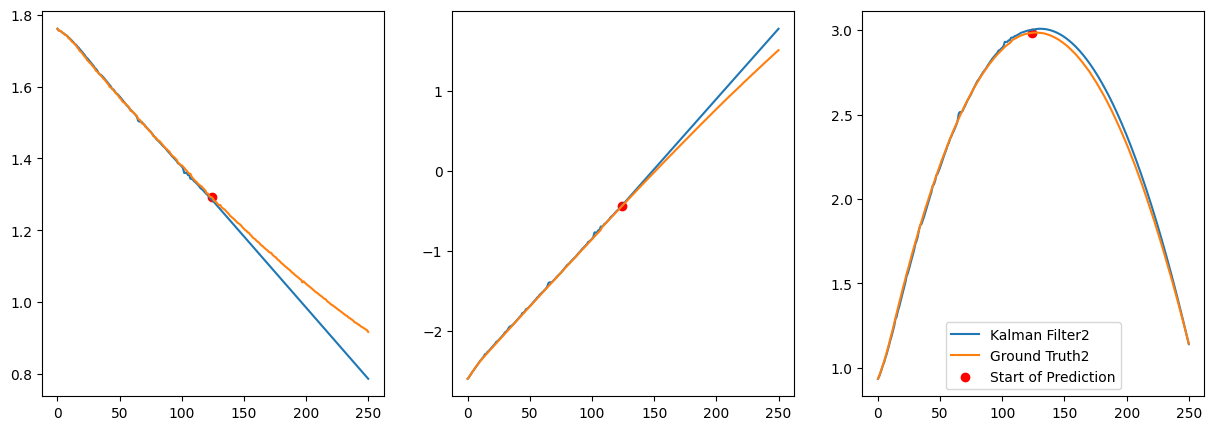

TypeError: list indices must be integers or slices, not tuple

In [8]:
# Create a Kalman Filter
P = np.array([[0.01,0,0,0.001,0,0],
            [0,0.01,0,0,0.001,0],
            [0,0,0.01,0,0,0.001],
            [500,0,0,5000000,0,0],
            [0,500,0,0,5000000,0],
            [0,0,500,0,0,5000000]])
for i in range(len(marker_pos)):
    throw_ = i
    marker_pos[throw_][1:,-1] -= marker_pos[throw_][:-1,-1]
    marker_pos[throw_][0,-1] = 0
    marker_pos[throw_][:,:3] = marker_pos[throw_][:,:3]/1000
    ekf = KalmanFilter()
    # ekf.P = P * np.array([[1/10**i,0,0,1,0,0],
    #                       [0,1/10**i,0,0,1,0],
    #                       [0,0,1/10**i,0,0,1],
    #                       [1/100**i,0,0,1/10**i,0,0],
    #                       [0,1/100**i,0,0,1/10**i,0],
    #                       [0,0,1/100**i,0,0,1/10**i]])
    div = 2
    lim = marker_pos[throw_].shape[0]//div
    ekf.x = np.array([marker_pos[throw_][0,0], marker_pos[throw_][0,1], marker_pos[throw_][0,2], 0, 0, 0]).reshape((6,1))
    
    ## Estimate the state using the Kalman Filter on the marker position
    for wp, marker_ in enumerate(marker_pos[throw_][:,:]):
        if(wp<lim):
            ekf.step(marker_[-1], marker_[:3])
        else:
            ekf.step()

    kf_state = np.array(ekf.X_hist)
    kf_cov = np.array(ekf.P_hist)
    ## Plot the trajectory of the marker and the Kalman Filter estimate of the marker position in the Z axis
    
    plt.figure(figsize=(15,5))
    for axis in range(3):
        #subplot 2x2
        plt.subplot(1,3,1+(axis))
        plt.plot(kf_state[:,axis], label = 'Kalman Filter'+str(axis))
        plt.plot(marker_pos[throw_][:,axis], label = 'Ground Truth'+str(axis))
        plt.scatter(int(lim-1),marker_pos[throw_][int(lim-1),axis],label = 'Start of Prediction', c = 'r')
    # plt.plot(kf_state[:,axis]-2*np.sqrt(kf_cov[:,axis,axis]), '--r')
    # plt.plot(kf_state[:,axis]+2*np.sqrt(kf_cov[:,axis,axis]), '--r')
    plt.legend()
    # plt.title('P {}'.format(ekf.P[3:,3:]))
    plt.show()
    plt.pause(0.05)
    
    

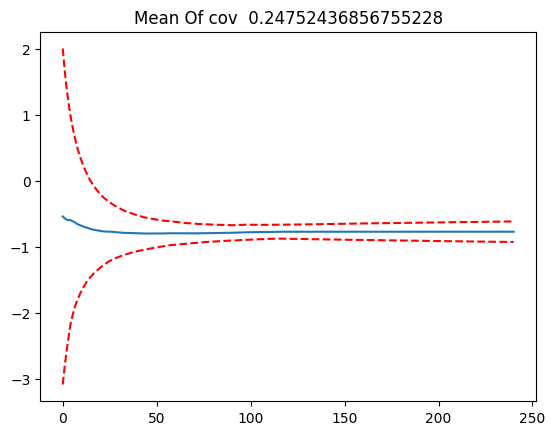

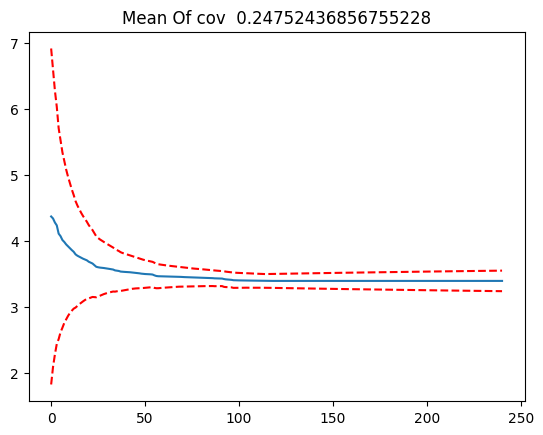

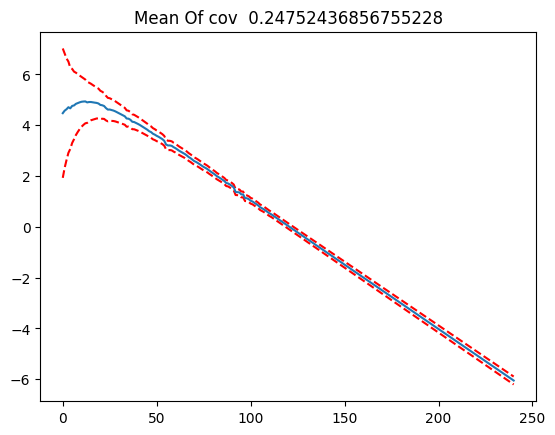

In [ ]:
start_point = 10
for i in [3,4,5]:
    plt.plot((kf_state[start_point:,i]-(np.sqrt(kf_cov[start_point:,i,i]) * 2).reshape(-1,1)), '--r')
    plt.plot((kf_state[start_point:,i]+(np.sqrt(kf_cov[start_point:,i,i]) * 2).reshape(-1,1)), '--r')
    plt.plot(kf_state[start_point:,i], label = 'Kalman Filter')
    plt.title("Mean Of cov  "+ str(((np.sqrt(kf_cov[start_point:,i,i]) * 2).reshape(-1,1)).mean()))
    plt.pause(0.05)